# Import and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

import GWfuncs
import gc
import pickle
import os
# import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

In [2]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
#in the paper xI0 = 0.866, but that would be non-equatorial case

traj = EMRIInspiral(func=KerrEccEqFlux)
amp = AmpInterpKerrEccEq() # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum()
ylm_gen = GetYlms(include_minus_m=False)

In [ ]:
# # Parameters
# M = 1e6
# mu = 1e1 
# a = 0.5
# p0 = 9.5
# e0 = 0.2
# theta = np.pi / 3.0 
# phi = np.pi / 4.0  
# dt = 10.0
# T = 1
# xI0 = 1.0 
# #in the paper xI0 = 0.866, but that would be non-equatorial case

# traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x")
# amp = AmpInterpKerrEqEcc(lmax=10,nmax=55) # default lmax=10, nmax=55
# interpolate_mode_sum = InterpolatedModeSum()
# ylm_gen = GetYlms(assume_positive_m=False)

# use_gpu = False
# func = "KerrEccentricEquatorial"

# # keyword arguments for inspiral generator 
# inspiral_kwargs={
#         "err": 1e-10,
#         "func": func,
#         "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
#         "include_minus_m": False, 
#         "use_gpu" : use_gpu,
#         "force_backend": "cuda12x"  # Force GPU
#         # "buffer_length": int(1e4),  # all of the trajectories will be well under len = 1000
#         # diff in v2.0: max init length => buffer length
#     }

# # keyword arguments for inspiral generator 
# amplitude_kwargs = {
#     "force_backend": "cuda12x"  # Force GPU
#     # "buffer_length": int(1e3),  # all of the trajectories will be well under len = 1000
#     # "use_gpu": use_gpu  # GPU is available in this class
# }

# # keyword arguments for Ylm generator (GetYlms)
# Ylm_kwargs = {
#     "force_backend": "cuda12x",  # Force GPU
#     "assume_positive_m": True  # if we assume positive m, it will generate negative m for all m>0
# }

# # keyword arguments for summation generator (InterpolatedModeSum)
# sum_kwargs = {
#     "force_backend": "cuda12x",  # Force GPU
#     # "use_gpu": use_gpu,  # GPU is available for this type of summation
#     "pad_output": False,
# }

# # Kerr eccentric flux
# few = FastKerrEccentricEquatorialFlux(
#     inspiral_kwargs=inspiral_kwargs,
#     amplitude_kwargs=amplitude_kwargs,
#     Ylm_kwargs=Ylm_kwargs,
#     sum_kwargs=sum_kwargs,
#     use_gpu=use_gpu,
# )


# Generate waveform

In [3]:
# Calc trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=dt)

# t_gpu = cp.asarray(t)

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

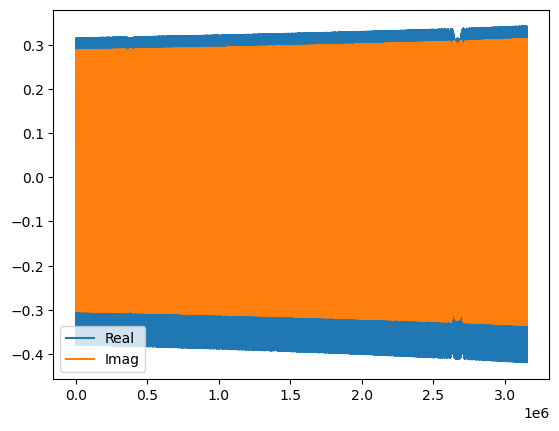

In [4]:
# need to prepare arrays for sum with all modes due to +/- m setup
ls = amp.l_arr[: teuk_modes.shape[1]]
ms = amp.m_arr[: teuk_modes.shape[1]]
ns = amp.n_arr[: teuk_modes.shape[1]]

keep_modes = np.arange(teuk_modes.shape[1])
temp2 = keep_modes * (keep_modes < amp.num_m0) + (keep_modes + amp.num_m_1_up) * (
    keep_modes >= amp.num_m0
) # amp.num_m0 gives number of modes with m == 0, amp.num_m_1_up gives number of modes with m > 0

ylmkeep = np.concatenate([keep_modes, temp2])
ylms_in = ylms[ylmkeep]
teuk_modes_in = teuk_modes

# perform summation
waveform1 = interpolate_mode_sum(
    t,
    teuk_modes_in,
    ylms_in,
    traj.integrator_spline_t,
    traj.integrator_spline_phase_coeff[:, [0, 2]],
    ls,
    ms,
    ns,
    dt=dt,
    T=T,
)

plt.plot(waveform1.real, label="Real")
plt.plot(waveform1.imag, label="Imag")
plt.legend(loc="lower left")

In [5]:
N = int(len(waveform1)) 
gwf = GWfuncs.GravWaveAnalysis(N=N,dt=dt)
# Calculate distance dimensionless
dist = 1.0 #Gpc
factor = gwf.dist_factor(dist, m2)
waveform1_scaled = waveform1/factor

In [6]:
hfull_f = gwf.freq_wave(waveform1_scaled)

SNR_ref = gwf.SNR(hfull_f)
print("SNR:", SNR_ref)
print("SNR squared:", SNR_ref**2)

SNR: 38.19708598849489
SNR squared: 1459.0173780124728


In [7]:
# Convert T to standard units
T_sd = 1.0 * YRSID_SI  # 1 sidereal year in seconds (~31,558,150 seconds)
print("Observation time in seconds:", T_sd)

Observation time in seconds: 31558149.763545595


In [8]:
N_traj = teuk_modes.shape[0]  # number of trajectory points
print("Number of trajectory points:", N_traj)
delta_T = T_sd / N_traj  # time step in seconds
print("Time step in seconds", delta_T)

Number of trajectory points: 11
Time step in seconds 2868922.705776872


# Generate mode frequencies

Using *get_fundamental_frequencies* instead

In [9]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [10]:
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x)

In [57]:
# trying older way to calc frequencies
Omega_phi = np.gradient(Phi_phi,t)/(2*np.pi)
Omega_theta = np.gradient(Phi_theta,t)/(2*np.pi)
Omega_r = np.gradient(Phi_r,t)/(2*np.pi)

# do i need div by 2pi?

In [58]:
np.max(np.abs(Omega_phi - OmegaPhi)),np.min(np.abs(Omega_phi - OmegaPhi))

(np.float64(0.03875370558116539), np.float64(0.031018172186804426))

In [59]:
np.max(np.abs(Omega_r - OmegaR)),np.min(np.abs(Omega_r - OmegaR))

(np.float64(0.025437760317396464), np.float64(0.021839487870832383))

In [60]:
gw_frequencies_per_mode = []
alt_gw_frequencies_per_mode = []


for idx in range(len(mode_labels)):
    l = amp.l_arr[idx]
    m = amp.m_arr[idx] 
    n = amp.n_arr[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi + n * OmegaR
    f_gw_alt = m * Omega_phi + n * Omega_r
    
    gw_frequencies_per_mode.append(f_gw)
    alt_gw_frequencies_per_mode.append(f_gw_alt)

In [61]:
gw_phase_per_mode = []
for idx in range(len(mode_labels)):
    l = amp.l_arr[idx]
    m = amp.m_arr[idx] 
    n = amp.n_arr[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi + n * Phi_r
    
    gw_phase_per_mode.append(phi_mode)

# Total power

In [25]:
m0mask = amp.m_arr_no_mask != 0
# Calculate power for all modes
total_power = gwf.calc_power(teuk_modes, ylms, m0mask)

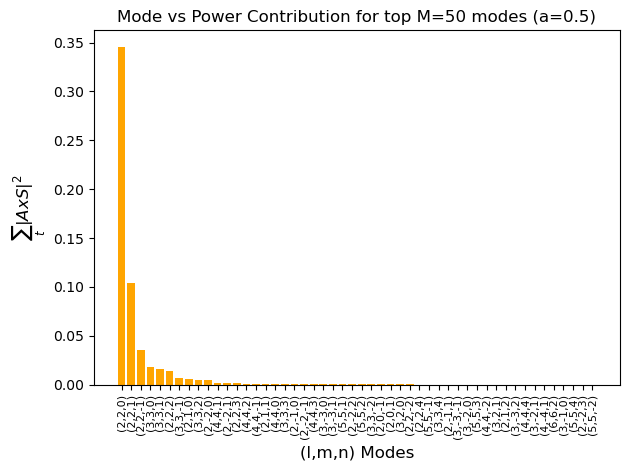

In [26]:
# Bar plot of modes vs approx inner product for top M modes 
M_mode = 50
mp = list(zip(mode_labels, total_power)) 
# Sort by power and pick top 100 modes
mp_sorted = sorted(mp, key=lambda x: x[1], reverse=True)[:M_mode]
mp_modes = [x[0] for x in mp_sorted]
mp_inner = [x[1] for x in mp_sorted]

plt.bar(range(len(mp_inner)), mp_inner, color='orange')
plt.xticks(range(len(mp_modes)), mp_modes, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\sum_{t} |AxS|^2$', fontsize=12)
plt.title('Mode vs Power Contribution for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('linear')
plt.tight_layout()
plt.show()


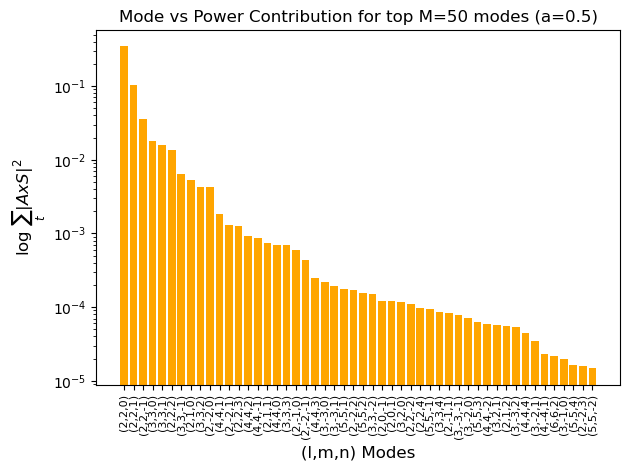

In [27]:
# Bar plot of modes vs approx inner product for top M modes 

plt.bar(range(len(mp_inner)), mp_inner, color='orange')
plt.xticks(range(len(mp_modes)), mp_modes, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'log $\sum_{t} |AxS|^2$', fontsize=12)
plt.title('Mode vs Power Contribution for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.show()


# Generate waveform of each mode

In [28]:
# Pick modes based on top 50 power contributions
top_indices = [mode_labels.index(mode) for mode in mp_modes]
print("Top mode indices:", top_indices)


Top mode indices: [1165, 1166, 1164, 1498, 1499, 1167, 1497, 1054, 1500, 7159, 1943, 7160, 1168, 1944, 1941, 1055, 1942, 1501, 7048, 7158, 1945, 7492, 7493, 2498, 7161, 2499, 1496, 54, 56, 1387, 1163, 1169, 2496, 1502, 7049, 7491, 7381, 2500, 1940, 1388, 1056, 7494, 1946, 7382, 7937, 3165, 7270, 2501, 7162, 2495]


In [44]:
waveform_per_mode = []
for idx in top_indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]
    print('Mode: ', mode_labels[idx])

    if m >= 0:
        # For m >= 0, directly use the mode
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        # Finding corresponding m>0 mode instead of mapping
        print('NEGATIVE M MODE')
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n) 
        print(amp.l_arr[pos_m_mask], amp.m_arr[pos_m_mask], amp.n_arr[pos_m_mask])
        pos_m_idx = np.where(pos_m_mask)[0]
        print(pos_m_idx)
        
        teuk_modes_single = (-1)**l * np.conj(teuk_modes[:, [pos_m_idx]])
        print(teuk_modes_single)
        # ylms_single = (-1)**(-m) * np.conj(ylms[[pos_m_idx]])
        ylms_single = ylms[[idx]]
        print(ylms_single)
        m_arr = np.abs(amp.m_arr[[idx]])  # To pass positive m 

    waveform = interpolate_mode_sum(
        t,
        teuk_modes_single,
        ylms_single,
        traj.integrator_spline_t,
        traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]], 
        m_arr,  
        amp.n_arr[[idx]], 
        dt=dt,
        T=T
    )
    waveform_per_mode.append(waveform/factor)

Mode:  (2,2,0)
Mode:  (2,2,1)
Mode:  (2,2,-1)
Mode:  (3,3,0)
Mode:  (3,3,1)
Mode:  (2,2,2)
Mode:  (3,3,-1)
Mode:  (2,1,0)
Mode:  (3,3,2)
Mode:  (2,-2,0)
NEGATIVE M MODE
[2] [2] [0]
[1165]
[[[0.44924664+0.12386828j]]

 [[0.44928771+0.12388589j]]

 [[0.44942348+0.12394409j]]

 [[0.44977097+0.1240931j ]]

 [[0.45083585+0.12455013j]]

 [[0.45487033+0.12628676j]]

 [[0.47595481+0.13548793j]]

 [[0.49535239+0.14412215j]]

 [[0.51475619+0.15289684j]]

 [[0.53413799+0.1617726j ]]

 [[0.54162553+0.16522501j]]]
[2.41402044e-18-0.03942395j]
Mode:  (4,4,1)
Mode:  (2,-2,1)
NEGATIVE M MODE
[2] [2] [1]
[1166]
[[[0.26093475+0.08208452j]]

 [[0.26093606+0.0820878j ]]

 [[0.26094042+0.08209865j]]

 [[0.26095151+0.08212639j]]

 [[0.26098504+0.08221107j]]

 [[0.26110611+0.08252764j]]

 [[0.26160121+0.08407366j]]

 [[0.26189359+0.08534002j]]

 [[0.26208225+0.08646406j]]

 [[0.26221704+0.08745186j]]

 [[0.26226515+0.08779906j]]]
[2.41402044e-18-0.03942395j]
Mode:  (2,2,3)
Mode:  (4,4,2)
Mode:  (4,4,-1)
Mode

In [45]:
# Convert each waveform to frequency domain
hf_per_mode = [gwf.freq_wave(waveform) for waveform in waveform_per_mode]

In [46]:
mode_labels_sel = [mode_labels[i] for i in top_indices]

# Calculate inner product (through noise-weighted inner product and power contribution)

In [47]:
inner_products = []
for i, mode in enumerate(hf_per_mode):
    inner_product = gwf.inner(mode,mode)
    inner_products.append(inner_product)

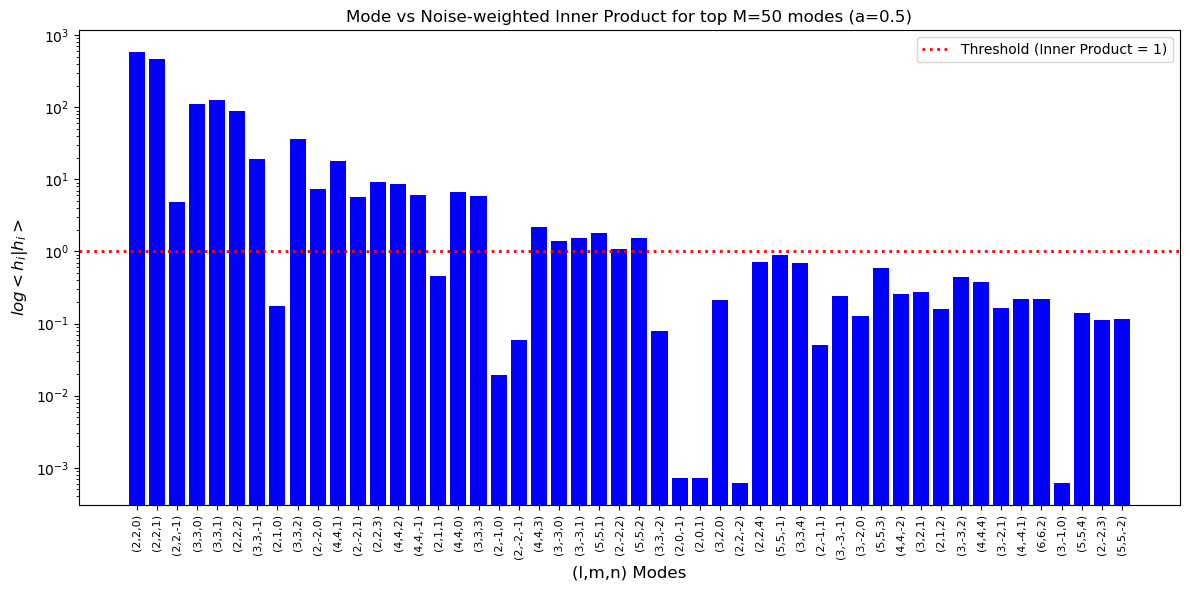

In [48]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(inner_products)), inner_products, color='blue')
plt.xticks(range(len(mode_labels_sel)), mode_labels_sel, rotation=90, fontsize=8)
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$log< h_i|h_i >$', fontsize=12)
plt.title('Mode vs Noise-weighted Inner Product for top M={} modes (a={})'.format(len(inner_products), a), fontsize=12)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
def calc_nw_power(teuk_modes, ylms, m0mask):
    # Calculate power for all modes
    full_modes = np.concatenate([teuk_modes, np.conj(teuk_modes[:, m0mask])], axis=1)
    h_lmn = full_modes * ylms[np.newaxis, :] # (time, modes)
    power = np.abs(h_lmn)**2
    print("Power shape:", power.shape)  # Shape: (N_traj, N_modes)
    
    # Get noise-weighted power for each mode
    nw_power = np.zeros_like(power)
    
    # Iterate through each mode
    for mode_idx in range(power.shape[1]):
        freq_mode = alt_gw_frequencies_per_mode[mode_idx] # change array of gw frequencies here 
        
        # Handle small / zero freq values -> replace with a small threshold
        zero_freq_mask = np.abs(freq_mode) < 1e-6
        freq_gw = np.where(zero_freq_mask, 1e-6, freq_mode)
        
        # Get noise PSD
        Sn_vals = get_sensitivity(freq_gw, sens_fn=LISASens, return_type="PSD")
        
        # Apply noise weighting
        nw_power[:, mode_idx] = power[:, mode_idx] / Sn_vals

    # Sum over trajectory points
    return np.sum(nw_power, axis=0)

In [50]:
teuk_modes.shape

(11, 6993)

In [51]:
ylms.shape[0]/2

6493.5

In [62]:
nw_power = calc_nw_power(teuk_modes, ylms, m0mask)
print("Noise-weighted inner product through power:", nw_power)

Power shape: (11, 12987)
Noise-weighted inner product through power: [2.15289283e+01 1.93467346e+02 9.43162864e+01 ... 2.76184307e+06
 2.00600813e+05 9.16487713e+06]


In [63]:
approx_inner = nw_power * delta_T * 1/(factor**2) * 4

Need factor of 2 or 4 due to *symmetry*?

In [64]:
# Select nw_power for top modes
top_approx_inner = [approx_inner[i] for i in top_indices]

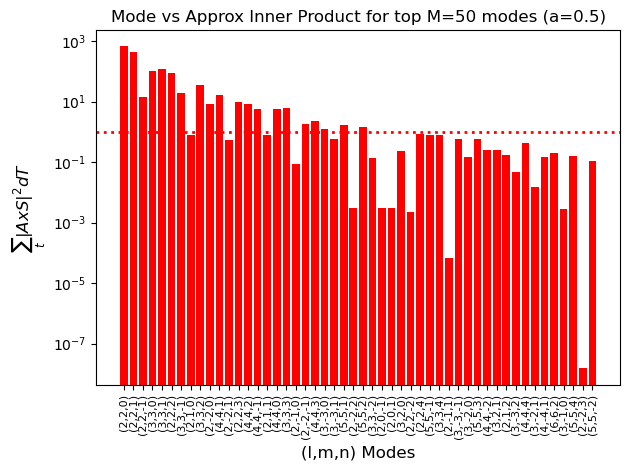

In [65]:
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.bar(range(M_mode), top_approx_inner, color='red')
plt.xticks(range(M_mode), mode_labels_sel, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\sum_{t} |AxS|^2 dT$', fontsize=12)
plt.title('Mode vs Approx Inner Product for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.show()


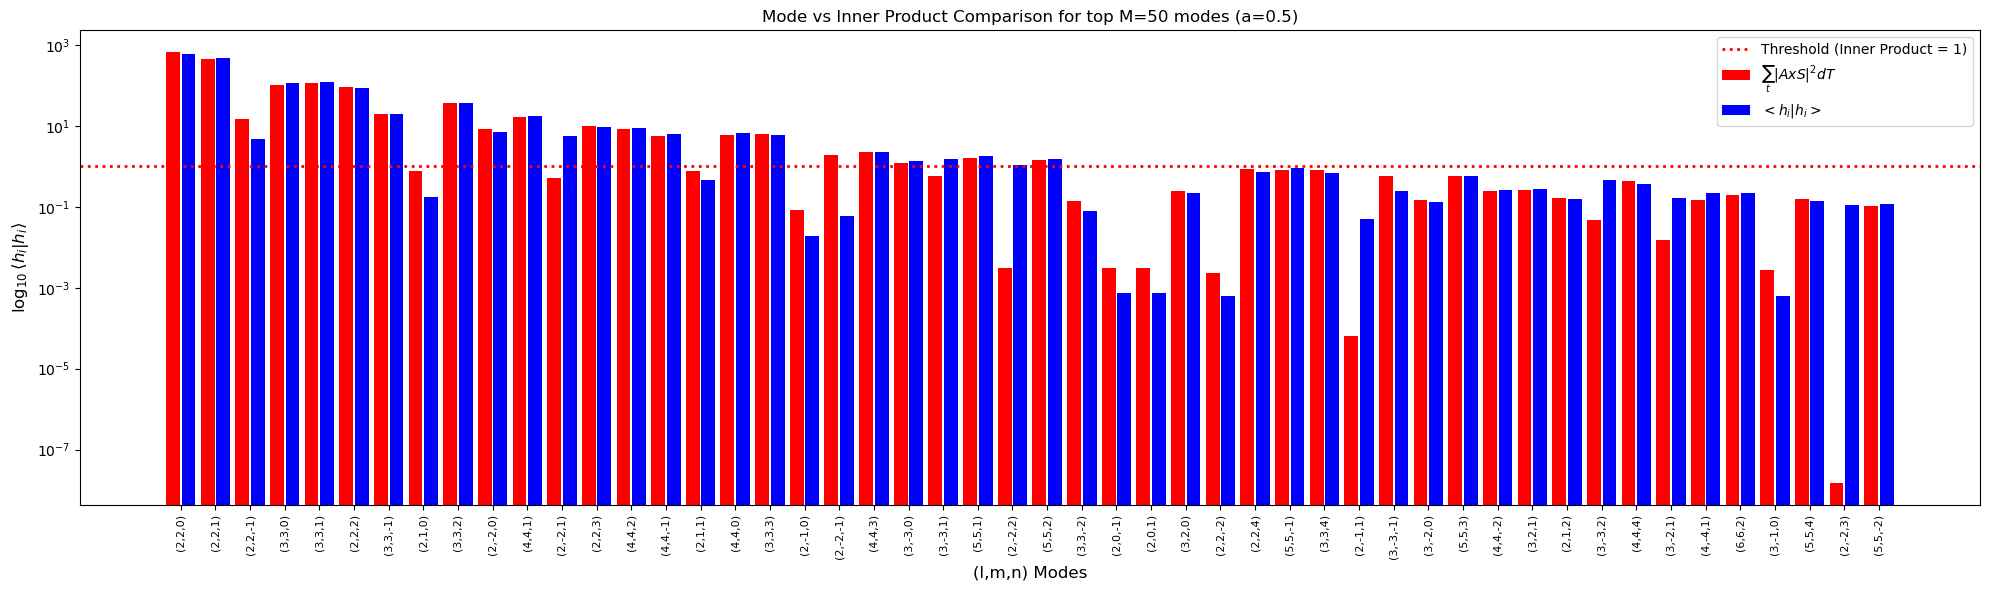

In [66]:
plt.figure(figsize=(20, 6))

bar_width = 0.4  
gap = 0.05
x_positions = np.arange(len(mode_labels_sel))
bars1 = plt.bar(x_positions - bar_width/2 - gap/2, top_approx_inner, bar_width,
                color='red', label=r'$\sum_{t} |AxS|^2 dT$')
bars2 = plt.bar(x_positions + bar_width/2 + gap/2, inner_products, bar_width,
                color='blue', label=r'$< h_i|h_i >$')
plt.xticks(x_positions, mode_labels_sel, rotation=90, fontsize=8)
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\log_{10} \langle h_i|h_i \rangle$', fontsize=12)
plt.title('Mode vs Inner Product Comparison for top M={} modes (a={})'.format(M_mode, a), fontsize=12)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

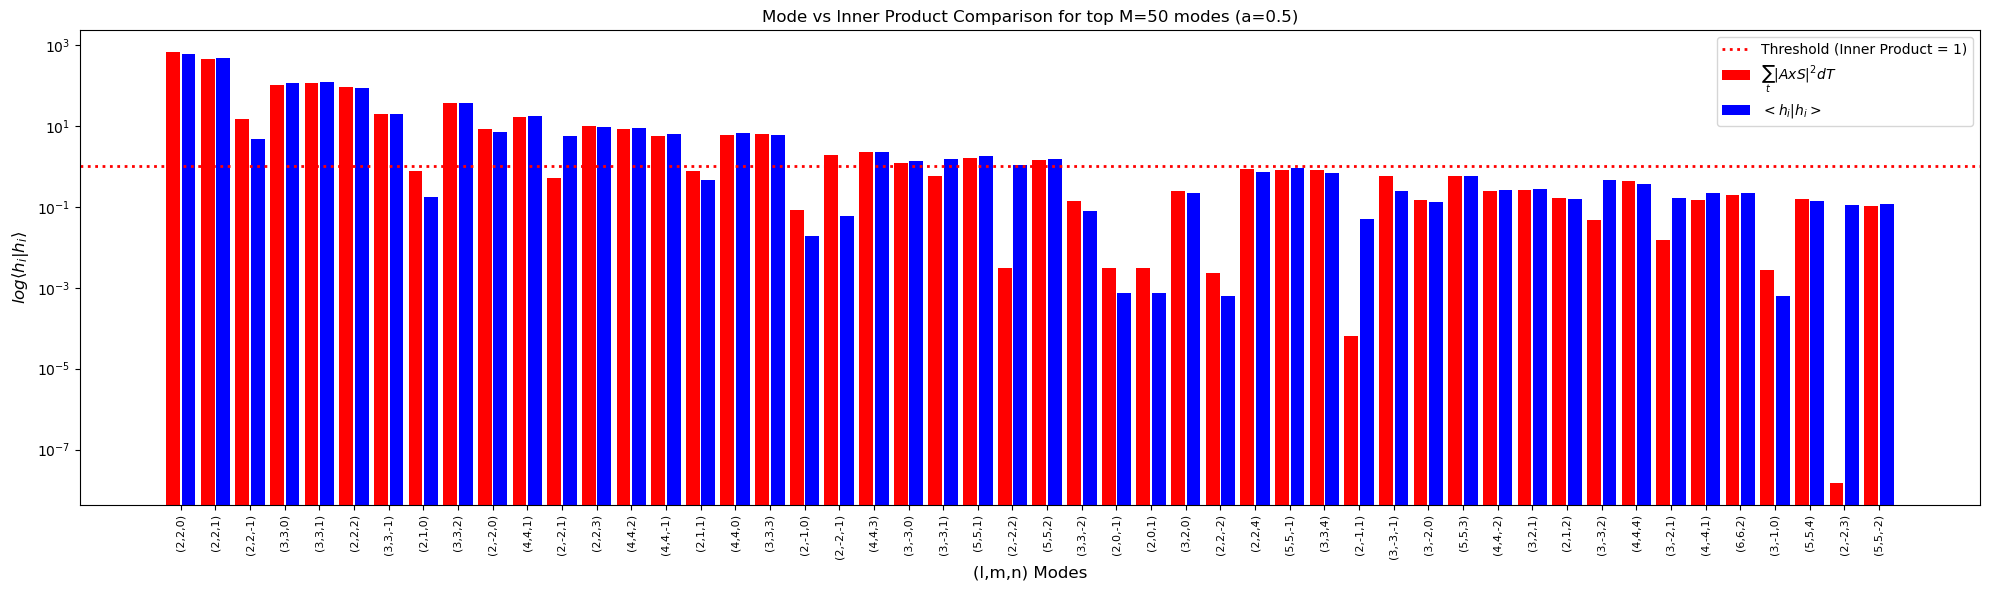

In [68]:
plt.figure(figsize=(20, 6))

bar_width = 0.4  
gap = 0.05
x_positions = np.arange(len(mode_labels_sel))
bars1 = plt.bar(x_positions - bar_width/2 - gap/2, top_approx_inner, bar_width,
                color='red', label=r'$\sum_{t} |AxS|^2 dT$')
bars2 = plt.bar(x_positions + bar_width/2 + gap/2, inner_products, bar_width,
                color='blue', label=r'$< h_i|h_i >$')
plt.xticks(x_positions, mode_labels_sel, rotation=90, fontsize=8)
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$log \langle h_i|h_i \rangle$', fontsize=12)
plt.title('Mode vs Inner Product Comparison for top M={} modes (a={})'.format(M_mode, a), fontsize=12)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Old algorithm with noise-weighted inner product

In [70]:
def modeselect_alg(hf_per_mode, inner_products, mode_labels, M_sel, inner_threshold=0.01):
    ##########################################
    ### Step 0: Initialize with strongest mode 
    ##########################################

    # Initialize combination counts
    combination_counts = {
        'rejected_modes': 0,
        'remaining_to_hM': 0, 
        'hM_with_selected': 0,
        'total': 0
    }

    # Track which modes were combined with each selected mode
    combined_modes_tracker = {}

    ## NOTE: I skipped the argsort here since I assume the inner_products are already sorted
    
    # Pick the strongest mode h_0
    sorted_indices = range(0,len(hf_per_mode))
    h0_idx = sorted_indices[0]
    
    # Initialize selected set S with h_0
    selected_modes = [hf_per_mode[h0_idx]]  
    selected_indices = [h0_idx]
    selected_labels = [mode_labels[h0_idx]]

    # Initialize tracking for the first selected mode
    combined_modes_tracker[0] = {'original': mode_labels[h0_idx], 'combined_with': []}

    # Keep track of all processed modes
    # Useful for combining remaining modes into h_M later
    processed_indices = [h0_idx]  
    
    print(f"Step 0: Selected strongest mode h_0: {mode_labels[h0_idx]} with inner product {inner_products[h0_idx]:.4e}")
    
    ###################################################
    # Step 1, 2, ... N: Iterate through remaining modes
    ###################################################  

    # Iterate till N_max to fulfill cond. <h_i|h_i> > 1 
    for i in range(1, len(hf_per_mode)):   
        # Check if we have reached the target number of modes
        if len(selected_modes) >= M_sel:
            print(f"\nReached target of {M_sel} selected modes.")
            break
            
        # Get the next candidate mode h_j'
        hj_prime_idx = sorted_indices[i]
        hj_prime = hf_per_mode[hj_prime_idx]
        processed_indices.append(hj_prime_idx)
        
        print(f"\n--- Iteration {i} ---")
        print(f"Currently have {len(selected_modes)} selected modes, target is {M_sel}")
        print(f"Candidate mode h_j': {mode_labels[hj_prime_idx]} with inner product {inner_products[hj_prime_idx]:.4e}")
        
        # Check max inner product w/ selected modes 
        max_inner = 0
        # Initialize index of mode w/ max inner product
        max_inner_idx = -1  
        
        for k, selected_mode in enumerate(selected_modes):
            # Calculate |<h_selected|h_j'>|
            calc_inner = abs(gwf.inner(selected_mode, hj_prime))
            print(f"  calc_inner with selected mode {k} ({selected_labels[k]}): {calc_inner:.6f}")

            # Update max inner product and index if this is the largest so far
            if calc_inner > max_inner:
                max_inner = calc_inner
                max_inner_idx = k
        
        # Check if max inner prod is below threshold
        if max_inner < inner_threshold:
            # Accept the mode
            selected_modes.append(hj_prime)
            selected_indices.append(hj_prime_idx)
            selected_labels.append(mode_labels[hj_prime_idx])
            
            # Initialize tracking for this new selected mode
            combined_modes_tracker[len(selected_modes)-1] = {
                'original': mode_labels[hj_prime_idx], 
                'combined_with': []
            }
            
            print(f"  ACCEPTED: Max inner product {max_inner:.6f} < {inner_threshold}")
            print(f"  Added mode: {mode_labels[hj_prime_idx]} (Total selected: {len(selected_modes)})")
        else:
            # Reject and add to most correlated mode
            print(f"  REJECTED: Max inner product {max_inner:.6f} >= {inner_threshold}")
            print(f"  Most correlated with: {selected_labels[max_inner_idx]}")
            
            # Track which mode was combined
            combined_modes_tracker[max_inner_idx]['combined_with'].append(mode_labels[hj_prime_idx])
            
            # Add h_j' to the most correlated mode h_k
            selected_modes[max_inner_idx] = selected_modes[max_inner_idx] + hj_prime
            combination_counts['rejected_modes'] += 1
            print(f"  Combined with mode: {selected_labels[max_inner_idx]}")
    
    ##########################################
    # Step N+1: Handle remaining modes as h_M
    ##########################################

    print(f"\n" + "="*50)
    print("STEP 2: Processing remaining modes as h_M")
    print("="*50)
    
    # Find all remaining modes not processed yet
    all_indices = set(range(len(hf_per_mode)))
    remaining_indices = list(all_indices - set(processed_indices))
    
    # Only process if there are remaining modes
    if remaining_indices:
        print(f"There are {len(remaining_indices)} remaining modes to combine into h_M")
        
        # Get labels of remaining modes for tracking
        remaining_mode_labels = [mode_labels[idx] for idx in remaining_indices]
        print(f"Remaining modes: {remaining_mode_labels}")
        
        # Sum all remaining modes to create h_M
        h_M = hf_per_mode[remaining_indices[0]]  
        for idx in remaining_indices[1:]:
            h_M = h_M + hf_per_mode[idx]
            combination_counts['remaining_to_hM'] += 1  
        
        # Check condition 1: <h_M|h_M> > 1 : True/False
        h_M_inner_product = gwf.inner(h_M, h_M)
        cond_one = h_M_inner_product > 1
        print(f"Condition 1: <h_M|h_M> = {h_M_inner_product:.6f} > 1? {cond_one}")
        
        # Check condition 2: <h_i|h_M> << 1 for all selected modes
        # Check inner products with selected modes and get the maximum inner product
        inners_with_selected = []
        max_inner_with_selected = 0
        max_inner_with_selected_idx = -1
        
        for k, selected_mode in enumerate(selected_modes):
            calc_inner = abs(gwf.inner(selected_mode, h_M))
            inners_with_selected.append(calc_inner)
            print(f"  <h_{k}|h_M> = {calc_inner:.6f}")
            
            # Update max inner product and index if this is the largest so far
            if calc_inner > max_inner_with_selected:
                max_inner_with_selected = calc_inner
                max_inner_with_selected_idx = k
        
        # Check if max inner product with selected modes is below threshold
        cond_two = max_inner_with_selected < inner_threshold
        print(f"Condition 2: max inner = {max_inner_with_selected:.6f} < {inner_threshold}? {cond_two}")
        
        # Decision logic
        print(f"\nDecision for h_M:")
        if cond_one and cond_two: # If both conditions are satisfied
            # Accept h_M as an extra mode
            selected_modes.append(h_M)
            selected_indices.append(-1)  # Special index for h_M
            selected_labels.append("h_M (remaining modes)")
            
            # Initialize tracking for h_M
            combined_modes_tracker[len(selected_modes)-1] = {
                'original': 'h_M', 
                'combined_with': remaining_mode_labels
            }
            
            print(f"  ACCEPTED h_M: Both conditions satisfied")
            print(f"  Added h_M as extra mode (Total selected: {len(selected_modes)})")
            
        elif not cond_one and cond_two: # If condition 1 is violated but condition 2 is satisfied
            # Throw away h_M (becomes error term)
            print(f"  DISCARDED h_M: Condition 1 violated, Condition 2 satisfied")
            print(f"  h_M becomes error/epsilon term")
             
        elif cond_one and not cond_two: # If condition 1 is satisfied but condition 2 is violated
            # Add h_M to most correlated selected mode
            print(f"  COMBINED h_M: Condition 1 satisfied, Condition 2 violated")
            print(f"  Most correlated with: {selected_labels[max_inner_with_selected_idx]}")
            
            # Track h_M combination
            combined_modes_tracker[max_inner_with_selected_idx]['combined_with'].extend(remaining_mode_labels)
            
            selected_modes[max_inner_with_selected_idx] = selected_modes[max_inner_with_selected_idx] + h_M
            combination_counts['hM_with_selected'] += 1 
            print(f"  Combined h_M with: {selected_labels[max_inner_with_selected_idx]}")
            
        else:  # If both conditions are violated
            # Throw away h_M
            print(f"  DISCARDED h_M: Both conditions violated")
            print(f"  h_M is thrown away")
    else:
        print("No remaining modes to process as h_M")
    
    if len(selected_modes) >= M_sel:
        print(f"\nReached target of {M_sel} selected modes.")
    else:
        print(f"\nProcessed all modes. Selected {len(selected_modes)} modes.")

    # Calculate total combinations
    combination_counts['total'] = (combination_counts['rejected_modes'] + 
                                  combination_counts['remaining_to_hM'] + 
                                  combination_counts['hM_with_selected'])
    
    ##########################################################
    # Calculate final inner products of selected modes
    ##########################################################
    print(f"\n" + "="*50)
    print("FINAL INNER PRODUCTS OF SELECTED MODES:")
    print("="*50)
    
    final_inner_products = []
    total_final_inner = 0
    
    for i, mode in enumerate(selected_modes):
        final_ip = gwf.inner(mode, mode)
        final_inner_products.append(final_ip)
        total_final_inner += final_ip
        
        # Get combination info for this mode
        mode_info = combined_modes_tracker[i]
        combined_info = ""
        if mode_info['combined_with']:
            combined_info = f" + {len(mode_info['combined_with'])} modes: {mode_info['combined_with']}"
        
        print(f"  <h_{i}|h_{i}> = {final_ip:.6f} | {mode_info['original']}{combined_info}")
    
    print(f"\nTotal final inner product: {total_final_inner:.6f}")
    print(f"Square root of total: {np.sqrt(total_final_inner):.6f}")
    
    ##########################################################
    # Detailed combination breakdown
    ##########################################################
    print(f"\n" + "="*50)
    print("COMBINATION BREAKDOWN:")
    print("="*50)
    
    for i, mode_info in combined_modes_tracker.items():
        if mode_info['combined_with']:
            print(f"Selected mode {i} ({mode_info['original']}):")
            print(f"  Combined with {len(mode_info['combined_with'])} modes: {mode_info['combined_with']}")
        else:
            print(f"Selected mode {i} ({mode_info['original']}): No combinations")
    
    print(f"\n" + "="*50)
    print("COMBINATION SUMMARY:")
    print("="*50)
    print(f"Rejected modes combined: {combination_counts['rejected_modes']}")
    print(f"Remaining modes combined into h_M: {combination_counts['remaining_to_hM']}")
    print(f"h_M combined with selected: {combination_counts['hM_with_selected']}")
    print(f"TOTAL COMBINATIONS: {combination_counts['total']}")
    
    return selected_modes, selected_indices, selected_labels, combination_counts, final_inner_products

In [71]:
sort_inner_products = sorted(zip(mode_labels_sel, inner_products), key=lambda x: x[1], reverse=True)
mode_labels_ip = [x[0] for x in sort_inner_products]
inner_products_sorted = [x[1] for x in sort_inner_products]

In [75]:
selected_modes_nw, selected_indices_nw, selected_labels_nw, combination_counts_nw, final_inner_products_nw  = modeselect_alg(
    hf_per_mode, inner_products_sorted, mode_labels_ip, M_sel=20, inner_threshold=0.01
)

Step 0: Selected strongest mode h_0: (2,2,0) with inner product 5.8578e+02

--- Iteration 1 ---
Currently have 1 selected modes, target is 20
Candidate mode h_j': (2,2,1) with inner product 4.6662e+02
  calc_inner with selected mode 0 ((2,2,0)): 0.005139
  ACCEPTED: Max inner product 0.005139 < 0.01
  Added mode: (2,2,1) (Total selected: 2)

--- Iteration 2 ---
Currently have 2 selected modes, target is 20
Candidate mode h_j': (3,3,1) with inner product 1.2444e+02
  calc_inner with selected mode 0 ((2,2,0)): 0.002051
  calc_inner with selected mode 1 ((2,2,1)): 0.000062
  ACCEPTED: Max inner product 0.002051 < 0.01
  Added mode: (3,3,1) (Total selected: 3)

--- Iteration 3 ---
Currently have 3 selected modes, target is 20
Candidate mode h_j': (3,3,0) with inner product 1.1135e+02
  calc_inner with selected mode 0 ((2,2,0)): 0.000850
  calc_inner with selected mode 1 ((2,2,1)): 0.002748
  calc_inner with selected mode 2 ((3,3,1)): 0.000426
  ACCEPTED: Max inner product 0.002748 < 0.01
 

In [76]:
N_fin_ip = len(selected_indices_nw)

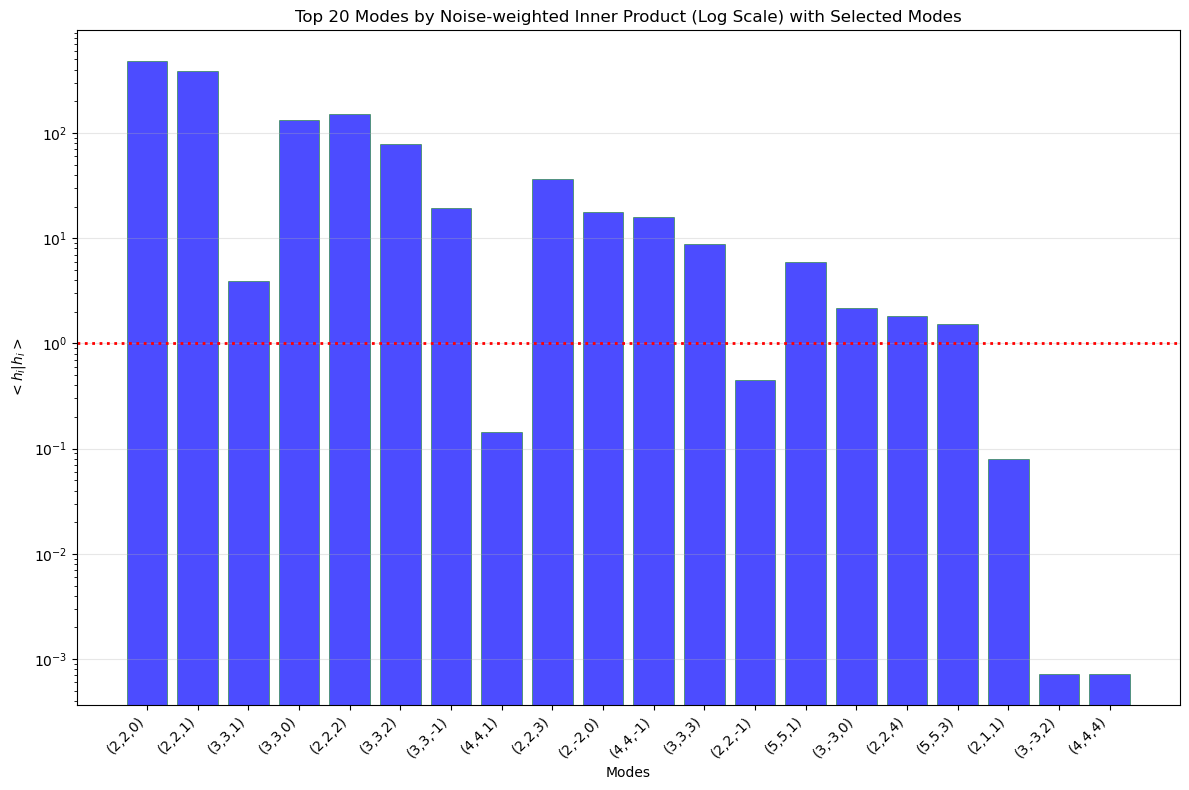

In [77]:
plt.figure(figsize=(12, 8))

# Create bar plot
bars = plt.bar(range(N_fin_ip), final_inner_products_nw, color='blue', alpha=0.7, edgecolor='green', linewidth=0.5)

# Set x-axis labels
plt.xticks(range(N_fin_ip), selected_labels_nw, rotation=45, ha='right', fontsize=10)
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')

       

plt.yscale('log')  # Log scale for better visibility
plt.xlabel('Modes')
plt.ylabel(r'$< h_i|h_i >$')
plt.title(f'Top {N_fin_ip} Modes by Noise-weighted Inner Product (Log Scale) with Selected Modes')
plt.tight_layout()
# plt.legend()
plt.grid(True, alpha=0.3, axis='y')  # Add horizontal grid lines
plt.show()

# STILL NEED TO FIX: New algorithm with power contribution

In [ ]:
# def calc_power_inner_nw(mode_i, mode_j, teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp):
#     """Calculate noise-weighted inner product using Cutler & Flanagan approximation"""
#     total_inner = 0.0 + 0.0j
    
#     for orig_idx_i in mode_i:
#         for orig_idx_j in mode_j:
#             # Map to teuk_modes indices
#             teuk_idx_i = map_to_teuk_indices([orig_idx_i], amp)[0]
#             teuk_idx_j = map_to_teuk_indices([orig_idx_j], amp)[0]
            
#             if orig_idx_i == orig_idx_j:
#                 # Self inner product - same as before
#                 teuk_mode = teuk_modes[:, teuk_idx_i]
#                 ylm = ylms[orig_idx_i]
                
#                 # Handle negative m conjugation
#                 m_i = amp.m_arr[orig_idx_i]
#                 l_i = amp.l_arr[orig_idx_i]
                
#                 if m_i < 0:
#                     teuk_mode = (-1)**l_i * np.conj(teuk_mode)
                
#                 h_lmn = teuk_mode * ylm
#                 power = np.abs(h_lmn)**2
                
#                 # Apply noise weighting
#                 f_gw_mode = gw_frequencies_per_mode[orig_idx_i]
#                 S_n_vals = get_sensitivity(f_gw_mode, sens_fn=LISASens, return_type="PSD")
#                 noise_weighted_power = power / S_n_vals
                
#                 inner_contrib = np.sum(noise_weighted_power) * delta_T * 1/(factor**2) * 4
                
#             else:
#                 # Cross terms - FIXED VERSION
#                 teuk_mode_i = teuk_modes[:, teuk_idx_i]
#                 teuk_mode_j = teuk_modes[:, teuk_idx_j]
                
#                 ylm_i = ylms[orig_idx_i]
#                 ylm_j = ylms[orig_idx_j]
                
#                 # Handle negative m conjugation
#                 m_i = amp.m_arr[orig_idx_i]
#                 m_j = amp.m_arr[orig_idx_j]
#                 l_i = amp.l_arr[orig_idx_i]
#                 l_j = amp.l_arr[orig_idx_j]
                
#                 if m_i < 0:
#                     teuk_mode_i = (-1)**l_i * np.conj(teuk_mode_i)
#                 if m_j < 0:
#                     teuk_mode_j = (-1)**l_j * np.conj(teuk_mode_j)
                
#                 # Calculate noise-weighted waveforms ĥ_α(t)
#                 h_i = teuk_mode_i * ylm_i
#                 h_j = teuk_mode_j * ylm_j
                
#                 f_gw_i = gw_frequencies_per_mode[orig_idx_i]
#                 f_gw_j = gw_frequencies_per_mode[orig_idx_j]
                
#                 # Get noise PSD square roots
#                 S_n_i_sqrt = np.sqrt(get_sensitivity(f_gw_i, sens_fn=LISASens, return_type="PSD"))
#                 S_n_j_sqrt = np.sqrt(get_sensitivity(f_gw_j, sens_fn=LISASens, return_type="PSD"))
                
#                 # Create noise-weighted waveforms (Eq. 45)
#                 h_hat_i = h_i / S_n_i_sqrt
#                 h_hat_j = h_j / S_n_j_sqrt
                
#                 # FIXED: Add complex conjugate for proper inner product
#                 cross_product = np.conj(h_hat_i) * h_hat_j
                
#                 # FIXED: Remove the factor of 4 (it's already in the self-terms)
#                 inner_contrib = np.sum(cross_product) * delta_T * 1/(factor**2)
            
#             total_inner += inner_contrib
    
#     return total_inner

In [ ]:
# def calc_power_inner_nw_window(mode_i, mode_j, teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp):
#     """Calculate noise-weighted inner product using Cutler & Flanagan approximation"""
#     total_inner = 0.0 + 0.0j
    
#     for orig_idx_i in mode_i:
#         for orig_idx_j in mode_j:
#             # Map to teuk_modes indices
#             teuk_idx_i = map_to_teuk_indices([orig_idx_i], amp)[0]
#             teuk_idx_j = map_to_teuk_indices([orig_idx_j], amp)[0]
            
#             if orig_idx_i == orig_idx_j:
#                 # Self inner product - same as before
#                 teuk_mode = teuk_modes[:, teuk_idx_i]
#                 ylm = ylms[orig_idx_i]
                
#                 # Handle negative m conjugation
#                 m_i = amp.m_arr[orig_idx_i]
#                 l_i = amp.l_arr[orig_idx_i]
                
#                 if m_i < 0:
#                     teuk_mode = (-1)**l_i * np.conj(teuk_mode)
                
#                 h_lmn = teuk_mode * ylm
#                 power = np.abs(h_lmn)**2
                
#                 # Apply noise weighting
#                 f_gw_mode = gw_frequencies_per_mode[orig_idx_i]
#                 S_n_vals = get_sensitivity(f_gw_mode, sens_fn=LISASens, return_type="PSD")
#                 noise_weighted_power = power / S_n_vals
                
#                 inner_contrib = np.sum(noise_weighted_power) * delta_T * 1/(factor**2) * 4
                
#             else:
#                 # Cross terms - FIXED VERSION
#                 teuk_mode_i = teuk_modes[:, teuk_idx_i]
#                 teuk_mode_j = teuk_modes[:, teuk_idx_j]
                
#                 ylm_i = ylms[orig_idx_i]
#                 ylm_j = ylms[orig_idx_j]
                
#                 # Handle negative m conjugation
#                 m_i = amp.m_arr[orig_idx_i]
#                 m_j = amp.m_arr[orig_idx_j]
#                 l_i = amp.l_arr[orig_idx_i]
#                 l_j = amp.l_arr[orig_idx_j]
                
#                 if m_i < 0:
#                     teuk_mode_i = (-1)**l_i * np.conj(teuk_mode_i)
#                 if m_j < 0:
#                     teuk_mode_j = (-1)**l_j * np.conj(teuk_mode_j)
                
#                 # Calculate noise-weighted waveforms ĥ_α(t)
#                 h_i = teuk_mode_i * ylm_i
#                 h_j = teuk_mode_j * ylm_j
                
#                 # Get GW frequencies for the modes
#                 f_gw_i = gw_frequencies_per_mode[orig_idx_i]
#                 f_gw_j = gw_frequencies_per_mode[orig_idx_j]

#                 # Get GW phase for the modes
#                 phi_i = gw_phase_per_mode[orig_idx_i]
#                 phi_j = gw_phase_per_mode[orig_idx_j]

#                 # Calculate phase difference evolution
#                 delta_phi = phi_i - phi_j
                
#                 # # Create phase mask: only include times when modes are "in phase"
#                 phase_mask = np.abs(delta_phi) < 1.0
#                 print("Phase mask:", phase_mask)
                
#                 # Get noise PSD square roots
#                 S_n_i_sqrt = np.sqrt(get_sensitivity(f_gw_i, sens_fn=LISASens, return_type="PSD"))
#                 S_n_j_sqrt = np.sqrt(get_sensitivity(f_gw_j, sens_fn=LISASens, return_type="PSD"))
                
#                 # Create noise-weighted waveforms (Eq. 45)
#                 h_hat_i = h_i / S_n_i_sqrt
#                 h_hat_j = h_j / S_n_j_sqrt
                
#                 # FIXED: Add complex conjugate for proper inner product
#                 cross_product = np.conj(h_hat_i[phase_mask]) * h_hat_j[phase_mask]
#                 print("Product of conj(hj)*hj':", cross_product)
                
#                 # FIXED: Remove the factor of 4 (it's already in the self-terms)
#                 inner_contrib = np.sum(cross_product) * delta_T * 1/(factor**2)
            
#             total_inner += inner_contrib
    
#     return total_inner

In [116]:
def calc_inner_try(mode_i, mode_j, teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp):
    """CALCULATING WITHOUT YLMS"""
    total_inner = 0.0 + 0.0j
    
    for orig_idx_i in mode_i:
        for orig_idx_j in mode_j:
            # Map to teuk_modes indices
            teuk_idx_i = map_to_teuk_indices([orig_idx_i], amp)[0]
            teuk_idx_j = map_to_teuk_indices([orig_idx_j], amp)[0]
            print(mode_labels[orig_idx_i], mode_labels[orig_idx_j])
            print(mode_labels[teuk_idx_i], mode_labels[teuk_idx_j])
            
            if orig_idx_i == orig_idx_j:
                # Self inner product - same as before
                teuk_mode = teuk_modes[:, teuk_idx_i]
                
                # Handle negative m conjugation
                m_i = amp.m_arr[orig_idx_i]
                l_i = amp.l_arr[orig_idx_i]
                
                if m_i < 0:
                    teuk_mode = (-1)**l_i * np.conj(teuk_mode)
                
                # h_lmn = teuk_mode * ylm
                power = np.abs(teuk_mode)**2
                
                # Apply noise weighting
                f_gw_mode = gw_frequencies_per_mode[orig_idx_i]
                S_n_vals = get_sensitivity(f_gw_mode, sens_fn=LISASens, return_type="PSD")
                noise_weighted_power = power / S_n_vals
                
                inner_contrib = np.sum(noise_weighted_power) * delta_T * 1/(factor**2) * 4
                
            else:
                # Cross terms - FIXED VERSION
                teuk_mode_i = teuk_modes[:, teuk_idx_i]
                teuk_mode_j = teuk_modes[:, teuk_idx_j]
                
                # ylm_i = ylms[orig_idx_i]
                # ylm_j = ylms[orig_idx_j]
                
                # Handle negative m conjugation
                m_i = amp.m_arr[orig_idx_i]
                m_j = amp.m_arr[orig_idx_j]
                l_i = amp.l_arr[orig_idx_i]
                l_j = amp.l_arr[orig_idx_j]
                
                if m_i < 0:
                    teuk_mode_i = (-1)**l_i * np.conj(teuk_mode_i)
                if m_j < 0:
                    teuk_mode_j = (-1)**l_j * np.conj(teuk_mode_j)
                
                # Calculate noise-weighted waveforms ĥ_α(t)
                # h_i = teuk_mode_i * ylm_i
                # h_j = teuk_mode_j * ylm_j
                h_i = teuk_mode_i
                h_j = teuk_mode_j
                
                # Get GW frequencies for the modes
                f_gw_i = gw_frequencies_per_mode[orig_idx_i]
                f_gw_j = gw_frequencies_per_mode[orig_idx_j]

                # Get GW phase for the modes
                phi_i = gw_phase_per_mode[orig_idx_i]
                phi_j = gw_phase_per_mode[orig_idx_j]

                # Calculate phase difference evolution
                delta_phi = phi_i - phi_j
                
                # Create phase mask: only include times when modes are "in phase"
                phase_mask = np.abs(delta_phi) < 1.0
                print(phase_mask)
                
                # Get noise PSD square roots
                S_n_i_sqrt = np.sqrt(get_sensitivity(f_gw_i, sens_fn=LISASens, return_type="PSD"))
                S_n_j_sqrt = np.sqrt(get_sensitivity(f_gw_j, sens_fn=LISASens, return_type="PSD"))
                
                # Create noise-weighted waveforms (Eq. 45)
                h_hat_i = h_i / S_n_i_sqrt
                h_hat_j = h_j / S_n_j_sqrt
                
                # FIXED: Add complex conjugate for proper inner product
                cross_product = np.conj(h_hat_i[phase_mask]) * h_hat_j[phase_mask]
                
                # FIXED: Remove the factor of 4 (it's already in the self-terms)
                inner_contrib = np.sum(cross_product) * delta_T * 1/(factor**2)
            
            total_inner += inner_contrib
    
    return total_inner

In [ ]:
def calc_power_inner_amponly(mode_i, mode_j, teuk_modes, delta_T, factor, gw_frequencies_per_mode, amp):
    """CALCULATING WITHOUT YLMS"""
    total_inner = 0.0 + 0.0j
    
    for idx_i in mode_i:
        for idx_j in mode_j:
            # For self inner product
            if idx_i == idx_j:
                teuk_mode = teuk_modes[:, idx_i]
                
                # Handle negative m conjugation
                m_i = amp.m_arr[idx_i]
                l_i = amp.l_arr[idx_j]
                
                if m_i < 0:
                    teuk_mode = (-1)**l_i * np.conj(teuk_mode)

                self_prod = np.conj(teuk_mode) * teuk_mode 

                # Apply noise weighting
                f_i = gw_frequencies_per_mode[idx_i]
                Sn_i = get_sensitivity(f_i, sens_fn=LISASens, return_type="PSD")

                bar_Ai_sq = self_prod / Sn_i
                
                # Why factor of 4 to make this work though..
                inner_contrib = np.sum(bar_Ai_sq) * delta_T * 1/(factor**2) 
                
            # For cross terms product
            else:
                teuk_mode_i = teuk_modes[:, idx_i]
                teuk_mode_j = teuk_modes[:, idx_j]
                
                # Handle negative m conjugation
                m_i = amp.m_arr[idx_i]
                m_j = amp.m_arr[idx_j]
                l_i = amp.l_arr[idx_i]
                l_j = amp.l_arr[idx_j]
                
                if m_i < 0:
                    teuk_mode_i = (-1)**l_i * np.conj(teuk_mode_i)
                if m_j < 0:
                    teuk_mode_j = (-1)**l_j * np.conj(teuk_mode_j)
                
                print("Teuk modes:", teuk_mode_i, teuk_mode_j)
                
                # Get GW frequencies for the modes
                f_i = gw_frequencies_per_mode[idx_i]
                f_j = gw_frequencies_per_mode[idx_j]

                # Get GW phase for the modes
                phi_i = gw_phase_per_mode[idx_i]
                phi_j = gw_phase_per_mode[idx_j]

                # Calculate phase difference evolution
                delta_phi = phi_i - phi_j
                phase_mask = np.abs(delta_phi) < 1.0
                print("Phase mask:", phase_mask)
                
                # Get noise PSD square roots
                Sn_i = get_sensitivity(f_i, sens_fn=LISASens, return_type="PSD")
                Sn_j = get_sensitivity(f_j, sens_fn=LISASens, return_type="PSD")
                
                # Noise weighted waveforms
                bar_Ai = teuk_mode_i / np.sqrt(Sn_i)
                bar_Aj = teuk_mode_j / np.sqrt(Sn_j)
                
                cross_prod = np.conj(bar_Ai[phase_mask]) * bar_Aj[phase_mask]
                print("Product of conj(Aj)*Aj':", cross_prod)
                
                inner_contrib = np.sum(cross_prod) * delta_T * 1/(factor**2)
            
            total_inner += inner_contrib
    
    return total_inner

In [114]:
np.real(calc_power_inner_amponly([1165], [1166], teuk_modes, delta_T, factor, gw_frequencies_per_mode, amp))

Teuk modes: [0.44924664-0.12386828j 0.44924666-0.12386829j 0.44924679-0.12386835j
 0.44924758-0.12386868j 0.44925227-0.1238707j  0.44928045-0.12388277j
 0.44944961-0.1239553j  0.45046868-0.12439248j 0.45673448-0.12709187j
 0.47238826-0.13391732j 0.48990391-0.14168195j 0.51672206-0.15379251j
 0.54157349-0.16520098j 0.5416294 -0.1652268j ] [0.26093475-0.08208452j 0.26093475-0.08208452j 0.26093475-0.08208453j
 0.26093478-0.08208459j 0.26093493-0.08208497j 0.26093583-0.08208722j
 0.26094125-0.08210074j 0.26097355-0.08218193j 0.26115894-0.08267163j
 0.26153211-0.08382475j 0.26182414-0.08499903j 0.26209755-0.08657027j
 0.26226481-0.08779671j 0.26226517-0.08779923j]
Phase mask: [ True  True  True False False False False False False False False False
 False False]
Product of conj(Aj)*Aj': [1.09715675e+38-3.92268049e+36j 1.09715690e+38-3.92268084e+36j
 1.09715832e+38-3.92268488e+36j]


np.float64(169.90769147478355)

In [115]:
np.real(calc_power_inner_amponly([1165], [1165], teuk_modes, delta_T, factor, gw_frequencies_per_mode, amp))

np.float64(1241.0547169970948)

In [97]:
abs(calc_inner_amponly([1165], [1166], teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp))

Teuk modes: [0.44924664-0.12386828j 0.44924666-0.12386829j 0.44924679-0.12386835j
 0.44924758-0.12386868j 0.44925227-0.1238707j  0.44928045-0.12388277j
 0.44944961-0.1239553j  0.45046868-0.12439248j 0.45673448-0.12709187j
 0.47238826-0.13391732j 0.48990391-0.14168195j 0.51672206-0.15379251j
 0.54157349-0.16520098j 0.5416294 -0.1652268j ] [0.26093475-0.08208452j 0.26093475-0.08208452j 0.26093475-0.08208453j
 0.26093478-0.08208459j 0.26093493-0.08208497j 0.26093583-0.08208722j
 0.26094125-0.08210074j 0.26097355-0.08218193j 0.26115894-0.08267163j
 0.26153211-0.08382475j 0.26182414-0.08499903j 0.26209755-0.08657027j
 0.26226481-0.08779671j 0.26226517-0.08779923j]
Phase mask: [ True  True  True False False False False False False False False False
 False False]
Product of conj(Aj)*Aj': [1.09715675e+38-3.92268049e+36j 1.09715690e+38-3.92268084e+36j
 1.09715832e+38-3.92268488e+36j]


np.float64(170.01625219780118)

In [93]:
teuk_modes_sorted[:,0].shape

(14,)

In [95]:
ylms_sorted = ylms[top_indices]
m0mask_sorted = m0mask[top_indices] if len(m0mask) > max(top_indices) else np.array([m0mask[i] if i < len(m0mask) else False for i in top_indices])


In [184]:
for i in range(len(top_indices)):
    print("=== Calculating for mode:", mode_labels[top_indices[i]])
    print("Time-domain:", abs(calc_power_inner_nw([top_indices[i]], [top_indices[i]], teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp)))
    print("Frequency-domain:", abs(gwf.inner(hf_per_mode[i], hf_per_mode[i])))

=== Calculating for mode: (2,2,0)
Time-domain: 624.9656024010035
Frequency-domain: 585.824012175421
=== Calculating for mode: (2,2,1)
Time-domain: 432.6252149261393
Frequency-domain: 466.6345702182539
=== Calculating for mode: (2,2,-1)
Time-domain: 13.475406617999992
Frequency-domain: 4.794699436952699
=== Calculating for mode: (3,3,0)
Time-domain: 92.28483029651026
Frequency-domain: 111.35713249843926
=== Calculating for mode: (3,3,1)
Time-domain: 112.98492310755181
Frequency-domain: 124.44182961172439
=== Calculating for mode: (2,2,2)
Time-domain: 89.33470970053438
Frequency-domain: 87.72344299750812
=== Calculating for mode: (3,3,-1)
Time-domain: 18.008433221176798
Frequency-domain: 19.426833287529305
=== Calculating for mode: (2,1,0)
Time-domain: 0.7010208241014362
Frequency-domain: 0.17458812411792546
=== Calculating for mode: (3,3,2)
Time-domain: 36.460286077796134
Frequency-domain: 36.310371930429774
=== Calculating for mode: (2,-2,0)
Time-domain: 7.715624721000029
Frequency-dom

In [185]:
abs(calc_power_inner_nw([1165], [1166], teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp))

np.float64(128.84932831429347)

In [194]:
abs(calc_power_inner_nw_window([1165], [1166], teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp))

[False False False False False False False False False False False False
 False False]


np.float64(0.0)

In [43]:
print("For mode:", mode_labels[top_indices[0]])
print("Power approx:", abs(calc_power_inner_nw_window([top_indices[0]], [top_indices[0]], teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp)))
print("Noise-weighted inner product:", abs(gwf.inner(hf_per_mode[0], hf_per_mode[0])))

For mode: (2,2,0)
Power approx: 624.9656024010035
Noise-weighted inner product: 585.8239700556379


In [53]:
print("For modes:", mode_labels[top_indices[0]],  mode_labels[top_indices[1]])
print("Power approx:", np.real(calc_power_inner_nw_window([top_indices[0]], [top_indices[1]], teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp)))
print("Noise-weighted inner product:", abs(gwf.inner(hf_per_mode[0], hf_per_mode[1])))

For modes: (2,2,0) (2,2,1)
Phase mask: [ True  True  True False False False False False False False False False
 False False]
Product of conj(hj)*hj': [1.38125504e+37-4.93842121e+35j 1.38125522e+37-4.93842166e+35j
 1.38125701e+37-4.93842673e+35j]
Power approx: 21.39036685909283
Noise-weighted inner product: 0.006326338103142443


In [98]:
print("For mode:", mode_labels[top_indices[0]],  mode_labels[top_indices[1]])
print("Power approx:", np.real(calc_inner_amponly([top_indices[0]], [top_indices[1]], teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp)))
print("Noise-weighted inner product:", abs(gwf.inner(hf_per_mode[0], hf_per_mode[1])))

For mode: (2,2,0) (2,2,1)
Teuk modes: [0.44924664-0.12386828j 0.44924666-0.12386829j 0.44924679-0.12386835j
 0.44924758-0.12386868j 0.44925227-0.1238707j  0.44928045-0.12388277j
 0.44944961-0.1239553j  0.45046868-0.12439248j 0.45673448-0.12709187j
 0.47238826-0.13391732j 0.48990391-0.14168195j 0.51672206-0.15379251j
 0.54157349-0.16520098j 0.5416294 -0.1652268j ] [0.26093475-0.08208452j 0.26093475-0.08208452j 0.26093475-0.08208453j
 0.26093478-0.08208459j 0.26093493-0.08208497j 0.26093583-0.08208722j
 0.26094125-0.08210074j 0.26097355-0.08218193j 0.26115894-0.08267163j
 0.26153211-0.08382475j 0.26182414-0.08499903j 0.26209755-0.08657027j
 0.26226481-0.08779671j 0.26226517-0.08779923j]
Phase mask: [ True  True  True False False False False False False False False False
 False False]
Product of conj(Aj)*Aj': [1.09715675e+38-3.92268049e+36j 1.09715690e+38-3.92268084e+36j
 1.09715832e+38-3.92268488e+36j]
Power approx: 169.90769147478355
Noise-weighted inner product: 0.006326338103142443


In [55]:
print("For modes:", mode_labels[top_indices[1]],  mode_labels[top_indices[2]])
print("Power approx:", np.real(calc_power_inner_nw_window([top_indices[1]], [top_indices[2]], teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp)))
print("Noise-weighted inner product:", abs(gwf.inner(hf_per_mode[1], hf_per_mode[2])))

For modes: (2,2,1) (2,2,-1)
Phase mask: [ True  True  True False False False False False False False False False
 False False]
Product of conj(hj)*hj': [-2.03499901e+36-1.86354861e+35j -2.03499923e+36-1.86354876e+35j
 -2.03500171e+36-1.86355073e+35j]
Power approx: -3.1514363634712494
Noise-weighted inner product: 0.001031581985760398


In [104]:
len(hf_per_mode)

50

In [105]:
abs(gwf.inner(hf_per_mode[0], hf_per_mode[1]))

np.float64(0.006326338103142443)

In [154]:
# Test with the actual individual mode waveforms that gwf.inner uses
orig_idx_i = top_indices[0]  # Use indices that correspond to hf_per_mode
orig_idx_j = top_indices[1] 

print(f"Testing modes {orig_idx_i} and {orig_idx_j}")
print(f"These correspond to hf_per_mode[0] and hf_per_mode[1]")

# Use the SAME waveforms that gwf.inner operates on
h_i_freq = hf_per_mode[0]
h_j_freq = hf_per_mode[1]

# Calculate using gwf.inner (reference)
gwf_result = abs(gwf.inner(h_i_freq, h_j_freq))
print(f"gwf.inner result: {gwf_result:.6f}")

# Calculate using your method
your_result = abs(calc_power_inner_nw([orig_idx_i], [orig_idx_j], teuk_modes, ylms, delta_T, factor, gw_frequencies_per_mode, amp))
print(f"Your method result: {your_result:.6f}")

# Calculate ratio
ratio = your_result / gwf_result
print(f"Ratio (yours/gwf): {ratio:.2f}")

Testing modes 1165 and 1166
These correspond to hf_per_mode[0] and hf_per_mode[1]
gwf.inner result: 0.006327
Your method result: 128.849328
Ratio (yours/gwf): 20363.60
